# Part I

I will use the same VAE architecture as before but set the latent variable $z$ to be $\gamma \sim N(0, 30)$ and have the model predict allele age from $X_l$.  

In [485]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [12]:
df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")

dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [21]:
dat[:,(0,2)]

array([[8.800e-03, 3.810e+02],
       [7.800e-03, 5.590e+02],
       [1.200e-03, 3.690e+02],
       ...,
       [9.876e-01, 2.631e+03],
       [3.060e-02, 7.050e+02],
       [8.898e-01, 1.044e+03]])

In [48]:
from sklearn.model_selection import train_test_split
# 85/15 split - creating a training data set of only (Xl, al) - no gamma
temp = train_test_split(np.log(dat[:,(0,2)]), test_size=0.15, random_state=42)

train_data = temp[0][:,0]
train_labs = temp[0][:,1]
test_data = temp[1][:,0]
test_labs = temp[1][:,1]

In [509]:
# get indices of ECDF sims using same test_train split seed
sims = pd.read_csv("traindata/sims-2021-08-16.csv.gz", compression='gzip', header=None)

In [16]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [91]:
intermediate_dim = 1024
latent_dim = 32
batch_size = 512
epsilon_std = 1.0
sigma2sq = np.sqrt(20.0).astype('float32')

def mse(y_true, y_pred):
    return keras.backend.sum(keras.metrics.mean_squared_error(y_true, y_pred), axis=-1)

# when z (i.e., \gamma) ~ N(\mu_2=0, \sigma_2) - can only do one latent dimension
# class KLDivergenceLayer(Layer):
#     """ Identity transform layer that adds KL divergence to the final model loss.
#     """
#     def __init__(self, *args, **kwargs):
#         self.is_placeholder = True
#         super(KLDivergenceLayer, self).__init__(*args, **kwargs)

#     def call(self, inputs):
#         mu, log_var = inputs
#         kl_batch = keras.backend.log(sigma2sq) - log_var + .5 * (keras.backend.exp(log_var) + keras.backend.square(mu))/sigma2sq - .5

#         self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
#         return inputs

# when z ~ N(0, 1) - but can do multiple dimensions i.e., MVN(0, I)
class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * keras.backend.sum(1 + log_var -
                                            keras.backend.square(mu) -
                                            keras.backend.exp(log_var), axis=-1)

        self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
        return inputs

# input is 1 dim - Xl
x = keras.Input(shape=(1,))
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(512, activation='relu')(x)
h = Dense(256, activation='relu')(h)

gamma_mu = Dense(latent_dim)(h)
gamma_log_var = Dense(latent_dim)(h)

gamma_mu, gamma_log_var = KLDivergenceLayer()([gamma_mu, gamma_log_var])
gamma_sigma = Lambda(lambda t: keras.backend.exp(.5*t))(gamma_log_var)

eps = keras.Input(tensor=keras.backend.random_normal(stddev=epsilon_std, shape=(keras.backend.shape(x)[0], latent_dim)))
gamma_eps = Multiply()([gamma_sigma, eps])
gamma = Add()([gamma_mu, gamma_eps])

# only need 1 output dim - allele age
decoder = keras.Sequential([
    Dense(256, input_dim=latent_dim, activation='relu'), 
    Dense(512, input_dim=256, activation='relu'),
    Dense(intermediate_dim, input_dim=512, activation='relu'), 
    Dense(1, activation='relu')
])

x_pred = decoder(gamma)
# symbolic representation
encoder = keras.Model(x, outputs=[gamma_mu, gamma_sigma])

In [92]:
vae = keras.Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=mse)

history = vae.fit((train_data, np.random.randn(train_data.shape[0],latent_dim)), train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True,
                    validation_data=((test_data, np.random.randn(test_data.shape[0],latent_dim)), test_labs), callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


.................................................................

In [93]:
gamma_preds = encoder.predict(test_data)
preds_mean_vae = np.exp(np.ravel(decoder.predict(gamma_preds[0])))

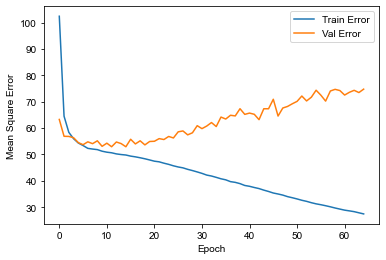

In [94]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

(array([[   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 2031., 5469.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0., 1499., 6001.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [1447.,  654.,  877.,  768.,  787.,  834.,  634.,  688.,  262.,
          549.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0., 7500.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.

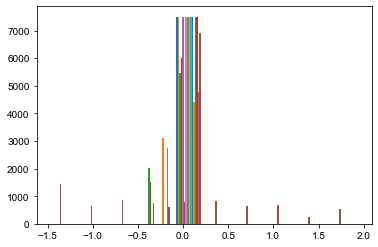

In [80]:
plt.hist(gamma_preds[0])

Text(40000, 2500, 'Intercept = 5488.94')

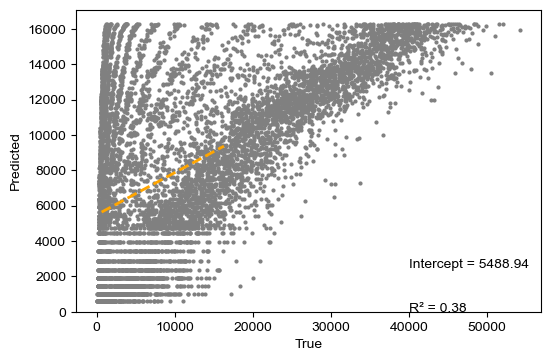

In [95]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds_mean_vae, 'o', color='grey', markersize=2)
plt.ylim(0)
res = sm.OLS(preds_mean_vae, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds_mean_vae), np.max(preds_mean_vae), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 10, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

# Part II

Below, I will ask the BaselineNet to learn the parameters of a $N(\mu, \sigma^2=0.25)$ since the $\log(a_l)$ is distributed normally, compared to the raw allele ages that are $\Gamma$ distributed. 

In [540]:
# gamma = np.unique(dat[:,1])
# idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]
# temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.15, random_state=42) for i in np.arange(len(gamma))]

# # for each gamma value...
# Xltrain = []
# Xltest = []
# altrain = []
# altest = []
# for t in np.arange(len(temp)):
#     Xltrain.append(temp[t][0])
#     Xltest.append(temp[t][1])
#     altrain.append(temp[t][2])
#     altest.append(temp[t][3])

# train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
# train_labs = np.log(np.hstack(altrain[0:50]))

# test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
# test_labs = np.log(np.hstack(altest[0:50]))

train_data, test_data, train_labs, test_labs = train_test_split(dat[:,(0,1)], np.log(dat[:,2]), test_size=0.15, random_state=42)

In [517]:
_, sims_test = train_test_split(sims.T, test_size=0.15, random_state=42)

In [621]:
x = keras.Input(shape=(2,))
h = Dense(512, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(256, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(128, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(64, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(16, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(1, activation='relu', kernel_initializer='random_uniform')(h)

#output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Gamma(tf.math.softplus(t[:,0]), tf.math.softplus(t[:,1])))(params)

## having just 1 free parameter works well...
output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(tf.math.softplus(t), 0.15))(params)

#output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(t[:,0], t[:,1]))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -tf.reduce_mean(p_y.log_prob(y))

param_model = keras.Model(prob_model.input, params)

prob_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [541]:
train_labs

array([8.14728826, 9.39648793, 9.80195304, ..., 9.71896357, 7.9280456 ,
       7.19218206])

(array([  25.,   97.,  234.,  505.,  595.,  766.,  882., 1310., 1728.,
        1358.]),
 array([ 4.07753744,  4.76051499,  5.44349253,  6.12647007,  6.80944761,
         7.49242515,  8.17540269,  8.85838023,  9.54135778, 10.22433532,
        10.90731286]),
 <BarContainer object of 10 artists>)

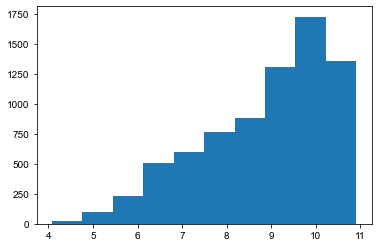

In [253]:
plt.hist(test_labs)

In [453]:
prob_model.fit(train_data, train_labs, epochs=2, shuffle=True)

Epoch 1/2
1329/1329 [==============================] - 3s 2ms/step - loss: 95.5158
Epoch 2/2
1329/1329 [==============================] - 2s 2ms/step - loss: 0.3815


In [622]:
history = prob_model.fit(train_data, train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


...................................................

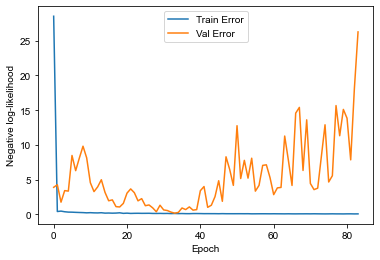

In [496]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Negative log-likelihood')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

In [543]:
pred_params = param_model.predict(test_data)
pred_params

array([[ 6.7010717],
       [10.388565 ],
       [ 5.2037063],
       ...,
       [10.4043045],
       [ 5.675272 ],
       [ 7.882901 ]], dtype=float32)

(array([  11.,   22.,   29.,   25.,   19.,   28.,  358.,  298., 1665.,
        5045.]),
 array([2108.7378, 2331.422 , 2554.1064, 2776.7908, 2999.475 , 3222.1594,
        3444.8438, 3667.528 , 3890.2124, 4112.8965, 4335.581 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

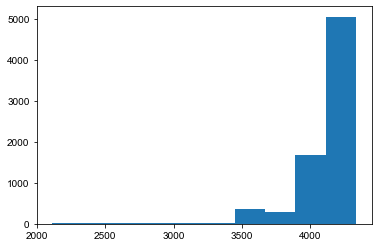

In [379]:
plt.hist(np.exp(pred_params[:,1]))

In [544]:
preds = np.exp(np.ravel(pred_params[:,0]))

(array([2424., 1028.,  713.,  584.,  528.,  477.,  414.,  426.,  409.,
         497.]),
 array([   76.94464,  4863.1294 ,  9649.314  , 14435.499  , 19221.684  ,
        24007.87   , 28794.053  , 33580.24   , 38366.42   , 43152.61   ,
        47938.793  ], dtype=float32),
 <BarContainer object of 10 artists>)

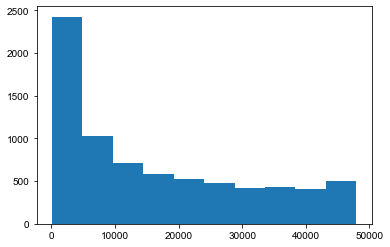

In [312]:
plt.hist(np.exp(pred_params[:,1]))

In [270]:
plt.hist(np.exp(np.ravel(test_labs)))

ValueError: supplied range of [1.0000000000004376, inf] is not finite

Text(40000, 2500, 'Intercept = 403.88')

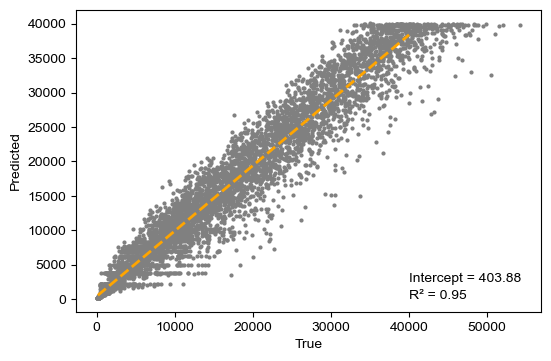

In [623]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds, 'o', color='grey', markersize=2)
res = sm.OLS(preds, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds), np.max(preds), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

In [624]:
# check if true values fall within 95% CI of the estimates
inctr = np.full(len(test_labs), False, dtype='bool')
for i in range(len(test_labs)):
    lb, ub = np.exp(pred_params[i,0] - 1.96*0.15), np.exp(pred_params[i,0] + 1.96*0.15)
    if np.exp(test_labs[i])>=lb and np.exp(test_labs[i])<=ub:
        inctr[i] = True

print('Accuracy: {:.2f}%'.format(100*np.sum(inctr)/len(test_labs)))

Accuracy: 85.55%


(array([  64.,  170.,  284.,  401.,  473.,  642.,  907., 1082., 1375.,
        2102.]),
 array([ 4.3430862,  4.9865456,  5.630005 ,  6.2734647,  6.916924 ,
         7.5603833,  8.203843 ,  8.847302 ,  9.490762 , 10.134221 ,
        10.77768  ], dtype=float32),
 <BarContainer object of 10 artists>)

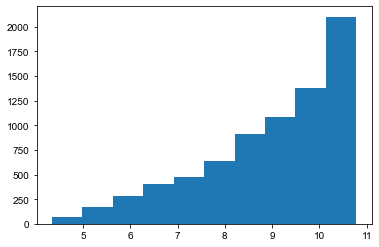

In [311]:
plt.hist(pred_params[:,1])

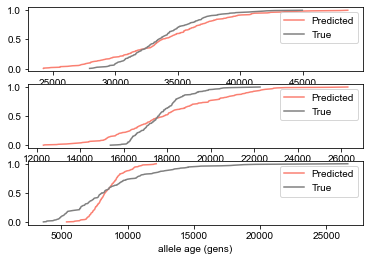

In [625]:
## compare ECDFs of the true allele ages and estimated distributions (3 examples)
# find that SD=0.1 is not great for all allele ages (as expected...)
plt.subplot(311)
e1 = ECDF(np.exp(np.random.normal(pred_params[789,0],0.15,200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.xlabel('allele age (gens)')
e2 = ECDF(sims_test.iloc[789,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

plt.subplot(312)
e1 = ECDF(np.exp(np.random.normal(pred_params[9,0],0.15,200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.xlabel('allele age (gens)')
e2 = ECDF(sims_test.iloc[9,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

plt.subplot(313)
e1 = ECDF(np.exp(np.random.normal(pred_params[111,0],0.15,200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.xlabel('allele age (gens)')
e2 = ECDF(sims_test.iloc[111,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

In [626]:
kst = np.empty((len(test_labs),2))
for i in range(len(test_labs)):
    kst[i,:] = scipy.stats.kstest(np.exp(np.random.normal(pred_params[i,0],0.15,200)),sims_test.iloc[i,:])

450 more pairs have significant differences with sd=0.25 when compared to sd=0.1 (best in test, increases again drastically for sd=0.05 and a little bit for sd=0.15) 


But decreasing the sd we see that a smaller percentage of 'true' values fall within the 95% CI of the estimate...seems like there is a balance at sd=0.15   

Again lowest accuracy when $|\gamma| < 0.02$ and $X_l < 5 \times 10^{-4}$ 

In [627]:
len(np.where(kst[:,1]<0.05)[0])

5686

Text(0.5, 1.0, 'KS-test value (brighter - more different)')

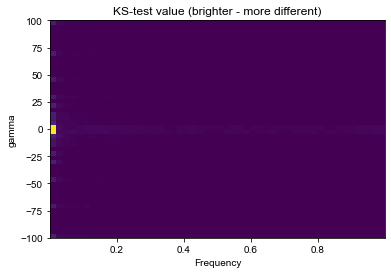

In [628]:
# query indices with highest kst (ONLY significant values)
kst_sig = np.where(kst[:,1]<0.05)[0]
plt.hist2d(test_data[kst_sig,0],test_data[kst_sig,1], [50,50])
plt.xlabel('Frequency')
plt.ylabel('gamma')
plt.title('KS-test value (brighter - more different)')

In [620]:
test_data[kst[kst_sig,0].argsort()[-5:][::-1],:]

array([[ 5.940000e-01, -1.467799e-01],
       [ 4.000000e-04,  6.812921e-02],
       [ 2.360000e-02, -1.000000e+00],
       [ 5.320000e-02,  3.162278e+00],
       [ 1.580000e-02, -2.154435e-01]])

array([0.007     , 0.01467799])

(array([ 6., 19., 51., 35., 38., 23.,  8.,  9.,  6.,  5.]),
 array([30435. , 32171.4, 33907.8, 35644.2, 37380.6, 39117. , 40853.4,
        42589.8, 44326.2, 46062.6, 47799. ]),
 <BarContainer object of 10 artists>)

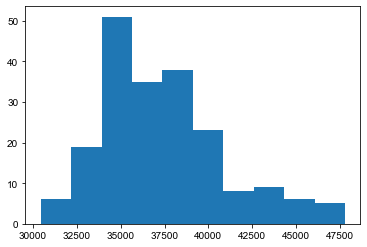

In [524]:
plt.hist(sims_test.iloc[57,:])

In [502]:
scipy.stats.kstest(np.random.normal(pred_params[57,0],0.25,200),np.random.normal(pred_params[55,0],0.25,200))

0.205

In [473]:
np.linspace(0,1,200)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

# Part III

Below, I will model the allele ages as coming from a $\Gamma(\alpha, \beta) = x^{\alpha - 1} e^{-x \beta} \beta^{\alpha}/ \Gamma(\alpha)$ distribution given $X_l$ and $\gamma$. The loss function needs to be defined as a negative log-likelihood of the $\Gamma$ distribution...

In [381]:
train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs =np.hstack(altrain[0:50])

test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.hstack(altest[0:50])

array([698., 194., 690., ..., 911., 179., 391.])

In [447]:
x = keras.Input(shape=(2,))
h = Dense(500, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(250, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(100, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(2, activation='relu', kernel_initializer='random_uniform')(h)

output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Gamma(tf.math.softplus(t[:,0]), tf.math.softplus(t[:,1])))(params)
#output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(tf.math.softplus(t[:,0]), 1e-3+tf.math.softplus(0.05*t[:,1])))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -tf.reduce_mean(p_y.log_prob(y))

param_model = keras.Model(prob_model.input, params)

prob_model.compile(optimizer=tf.optimizers.SGD(learning_rate=1e-3), loss=negloglik)

In [416]:
train_labs

array([698., 194., 690., ..., 911., 179., 391.])

In [448]:
history = prob_model.fit(train_data, train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


...................................................

In [449]:
pred_params = param_model.predict(test_data)
pred_params

array([[1.2352128e+14, 2.6071589e+17],
       [1.2400869e+14, 2.6174462e+17],
       [1.2351158e+14, 2.6069541e+17],
       ...,
       [9.9732764e+13, 2.1050566e+17],
       [9.9213157e+13, 2.0940893e+17],
       [9.9379671e+13, 2.0976040e+17]], dtype=float32)

Text(40000, 2500, 'Intercept = 1163.16')

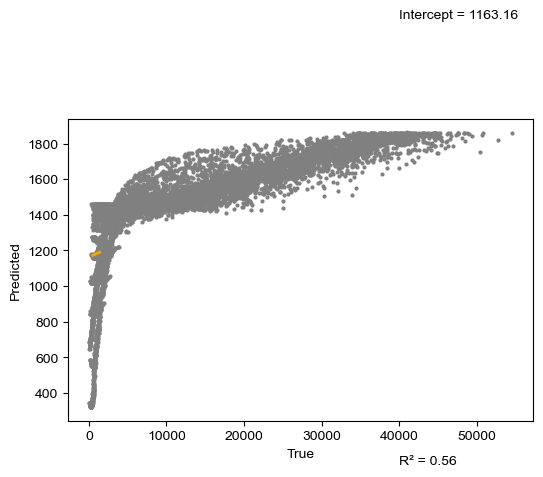

In [442]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(test_labs, pred_params[:,0], 'o', color='grey', markersize=2)
res = sm.OLS(pred_params[:,0], sm.add_constant(test_labs)).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(pred_params[:,0]), np.max(pred_params[:,0]), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))